# Installation et mise en place de l'environnement


In [1]:
!pip install -U scikit-image
!pip install opencv-python
!pip install light-the-torch && ltt install torch
!pip install torchio
!pip install Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 20.8 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pillow-8.4.0
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.19.3
    Uninstalling scikit-image-0.19.3:
      Successfully uninstalled scikit-image-0.19.3


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.8/172.8 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.5/237.5 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 6.8 MB/s eta 0:00:00
  Attempting uninstall: rich
    Found existing installation: rich 13.3.4
    Uninstalling rich-13.3.4:
      Successfully uninstalled rich-13.3.4


In [ ]:
#import os
#os.kill(os.getpid(), 9)

In [28]:
from PIL import Image
PIL.__version__

'8.4.0'

In [2]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import os
import itertools
from scipy.spatial.distance import cdist
from skimage.metrics import structural_similarity as compare_ssim
import PIL
from PIL import Image

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

!ln -s /content/gdrive/My\ Drive/ /mydrive

%cd /mydrive/PLDAC

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
ln: failed to create symbolic link '/mydrive/My Drive': File exists
/content/gdrive/My Drive/PLDAC


# Récupération des images et de leurs coordonées


In [11]:
path_images = "original_images"

In [20]:
def load_images(path, gray_scale = False):
  """
  On charge les images et on les mets toutes avec les mêmes dimensions
  """
  images = []
  names = []
  for f in os.listdir(path):
      if f[-4:] == '.bmp' :
          img = None
          if gray_scale : 
              img = cv2.imread(os.path.join(path, f), gray_scale)
          else :
              img = cv2.imread(os.path.join(path, f))
          if img is not None:
              img = cv2.resize(img, (1024,1024))
              images.append(img) 
              names.append(f)
  return images, names

images,names = load_images(path_images)
names = names[0:-1]

In [23]:
path_labels = "original_images"

In [24]:
def load_labels(path):
  """
  On charge les labels 
  """
  labels = []
  names = os.listdir(path)
  for f in os.listdir(path):
    if f[-4:]==".txt" :
      with open(path+'/'+f,'r') as fp:
        ligne = fp.readline()
        liste = ligne.split(' ')
        labels.append(liste)
  return labels, names

labels,names = load_labels(path_labels)

# Dessiner les bbox sur les images

In [26]:
def rectangle(img,label):
  # load image
  #img = cv2.imread(image)
  #load label
  with open(label) as fp:
    ligne = fp.readline()
    liste = ligne.split(' ')
  # shape image
  n , m , c = img.shape
  # coordonnées
  x_center = int(float(liste[1]) * m)
  y_center = int(float(liste[2]) * n)
  width = int(float(liste[3]) * m)
  height = int(float(liste[4]) * n)
  x1 = int(x_center - 0.5 * width)
  y1 = int(y_center - 0.5 * height)
  x2 = int(x_center + 0.5 * width)
  y2 = int(y_center + 0.5 * height)
  # draw rectangle on image
  img_modif = img.copy()
  cv2.rectangle(img_modif, (x1, y1), (x2, y2), (0, 0, 255),thickness = 2)
  return img_modif


In [27]:
def rectangle_liste(img_liste,label_liste):
  img_modif_liste = []
  for i in range(len(img_liste)):
    n , m , c = img_liste[i].shape
    # coordonnées
    x_center = int(float(label_liste[i][1]) * m)
    y_center = int(float(label_liste[i][2]) * n)
    width = int(float(label_liste[i][3]) * m)
    height = int(float(label_liste[i][4]) * n)
    x1 = int(x_center - 0.5 * width)
    y1 = int(y_center - 0.5 * height)
    x2 = int(x_center + 0.5 * width)
    y2 = int(y_center + 0.5 * height)
    # draw rectangle on image
    img_modif = img_liste[i].copy()
    img_modif =cv2.rectangle(img_modif, (x1, y1), (x2, y2), (0, 0, 255),thickness = 2)
    img_modif_liste.append(img_modif)
  return img_modif_liste


0038402.txt
(1024, 1024, 3)


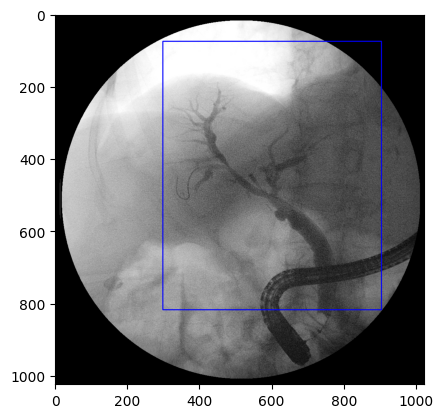

In [29]:
l = rectangle_liste(images[0:5],labels[0:5])
print(names[0])
print(l[0].shape)
plt.imshow(l[4])


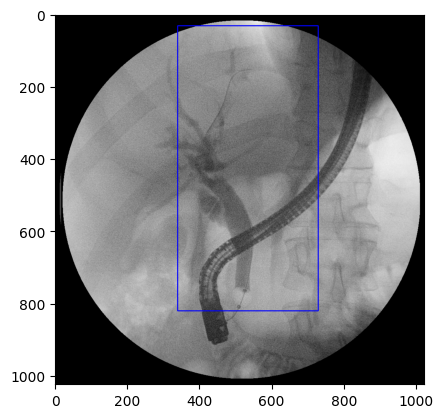

In [34]:
num_image = 2
file_name = str("original_images/"+names[num_image][:-4]+".txt")
image_label = rectangle(images[num_image], file_name)
plt.imshow(image_label)

#Affichage de toutes les images


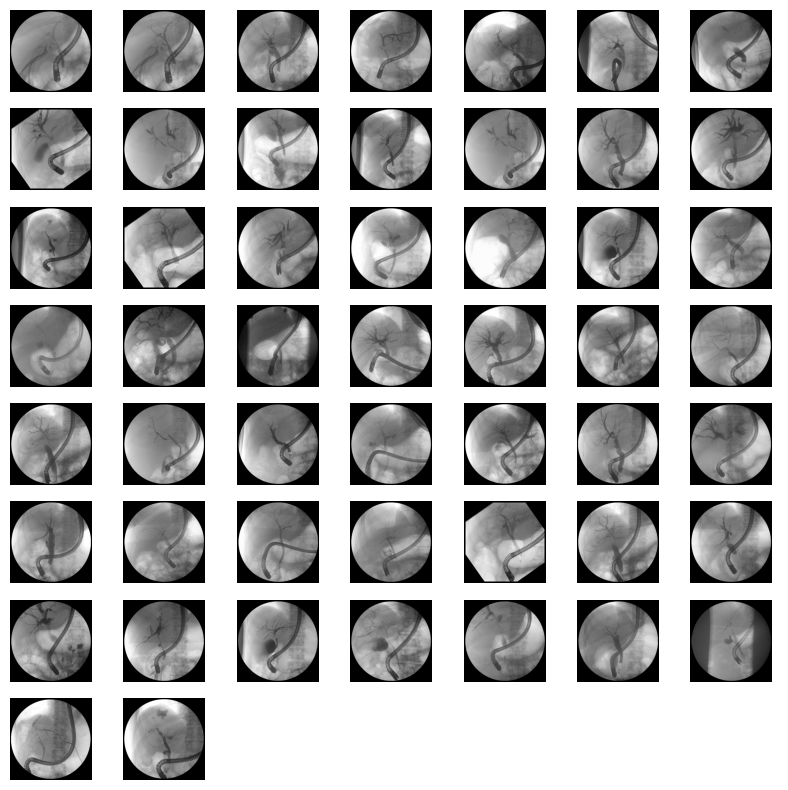

In [37]:
def affiche_images(path):
    images,names = load_images(path) 

    fig, axes = plt.subplots(nrows=9, ncols=6, figsize=(15, 15))
    for ax, img in zip(axes.ravel(), images):
        ax.imshow(img)
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()


import math
def affiche_images(path):
  images, names = load_images(path)
  num_images = len(images)

  # Définir la taille de la grille
  rows = math.ceil(math.sqrt(num_images))
  cols = math.ceil(num_images / rows)

  # Créer une grille de sous-graphiques
  fig, axs = plt.subplots(rows, cols, figsize=(10, 10))

  # Parcourir toutes les images et les afficher
  for i, ax in enumerate(axs.flat):
      if i < num_images:
          ax.imshow(images[i])
          ax.axis('off')
      else:
          ax.axis('off')

  plt.show()

affiche_images(path_images)




# Affichage de l'image moyenne

In [38]:
def image_moyenne(path):
  images,_ = load_images(path)
  w,h,c = np.array(images[0]).shape #toutes les images ont les mêmes dimensions (width, height, color space)

  # Calcul de l'image moyenne
  avg_image = np.zeros((h, w, c), np.float32)

  for img in images:
      avg_image += np.array(img) / len(images)

  avg_image = np.round(avg_image).astype(np.uint8)

  return avg_image

avg_image = image_moyenne(path_images)

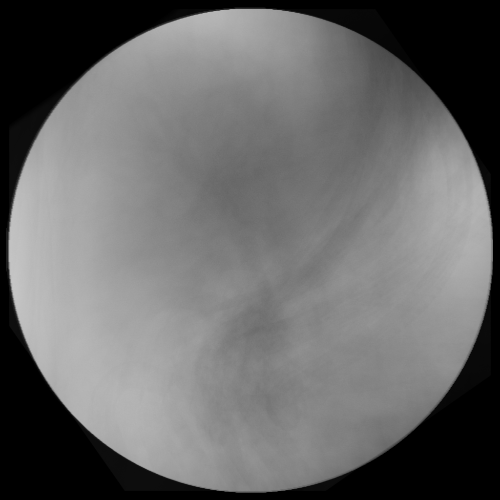

In [39]:
avg_image_resize = cv2.resize(avg_image, (500,500))
cv2_imshow(avg_image_resize)
hist = cv2.calcHist([avg_image],[0],None,[256],[0,256])

# Similitudes de couleurs 


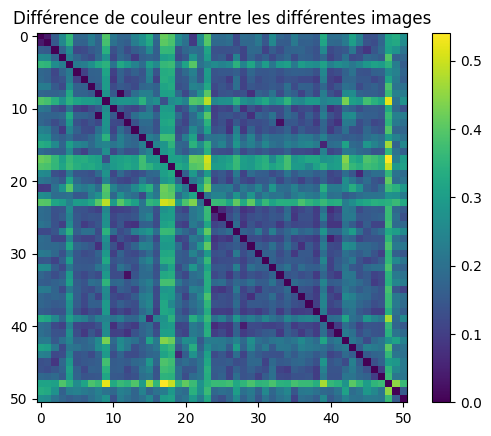

In [40]:
def similarityColor(path):
    images,_ = load_images(path)

    similarity_matrix = np.zeros((len(images), len(images)))

    for i, j in itertools.combinations(range(len(images)), 2):
        hist1 = cv2.calcHist([images[i]],[0],None,[256],[0,256])
        hist2 = cv2.calcHist([images[j]],[0],None,[256],[0,256])
        corr = cv2.compareHist(hist1, hist2, cv2.HISTCMP_BHATTACHARYYA) #compare how well two histograms match witheach other
        similarity_matrix[i, j] = corr
        similarity_matrix[j, i] = corr
 
    plt.imshow(similarity_matrix)
    plt.colorbar()
    plt.title("Différence de couleur entre les différentes images")
    plt.show()

similarityColor(path_images)

# Histogrammes

In [41]:
def histo(img):
  hist,bins = np.histogram(img.flatten(),256,[0,256])
  plt.plot(hist)
  plt.show()

def histo_eq(img):
  hist,bins = np.histogram(img.flatten(),256,[0,256])
  cdf = hist.cumsum()
  cdf_normalized = cdf * float(hist.max()) / cdf.max()
  plt.plot(cdf_normalized, color = 'b')
  plt.hist(img.flatten(),256,[0,256], color = 'r')
  plt.xlim([0,256])
  plt.legend(('cdf','histogram'), loc = 'upper left')
  plt.show()

def img_modif_histo_eq(img):
  hist,bins = np.histogram(img.flatten(),256,[0,256])
  cdf = hist.cumsum()
  cdf_normalized = cdf * float(hist.max()) / cdf.max()
  cdf_m = np.ma.masked_equal(cdf,0)
  cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
  cdf = np.ma.filled(cdf_m,0).astype('uint8')
  img2 = cdf[img]
  return img2

def histo_stretch(img):
  mini = img.flatten().min()
  maxi = img.flatten().max()
  img2 = ((img-mini)/(maxi-mini))*255
  hist,bins = np.histogram(img2.flatten(),256,[0,256])
  plt.hist(img.flatten(),256,[0,256], color = 'r')
  plt.show()

def img_modif_histo_stretch(img):
  mini = img.flatten().min()
  maxi = img.flatten().max()
  img2 = ((img-mini)/(maxi-mini))*255
  return img2



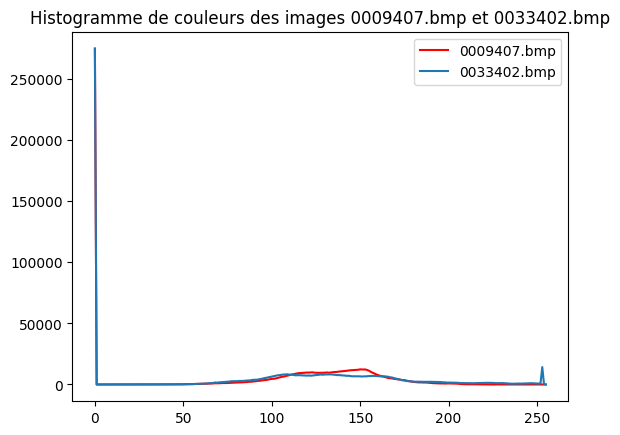

In [42]:
def affiche_hist_i_j(path, i,j):
    images,names = load_images(path)
    hist1 = cv2.calcHist([images[i]],[0],None,[256],[0,257])
    hist2 = cv2.calcHist([images[j]],[0],None,[256],[0,257])
    plt.figure()
    plt.plot(hist1,'r', label=names[i])
    plt.plot(hist2, label=names[j])
    plt.legend()
    plt.title("Histogramme de couleurs des images "+str(names[i])+" et "+str(names[j]))
    plt.show()

affiche_hist_i_j(path_images,0,16)

# Mesure similarités




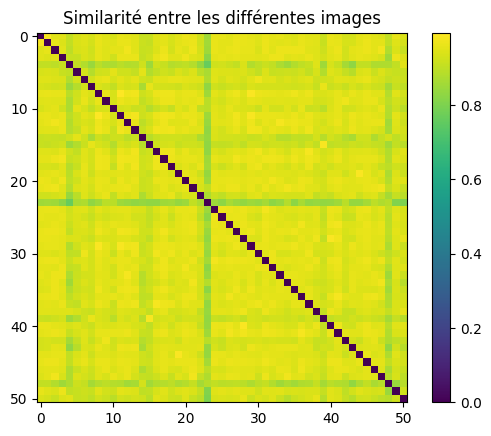

In [43]:
def similarity(path):
    images,_ = load_images(path)

    similarity_matrix = np.zeros((len(images), len(images)))

    for i, j in itertools.combinations(range(len(images)), 2):
        #corrélation croisée normalisée
        corr = cv2.matchTemplate(images[i], images[j], cv2.TM_CCORR_NORMED) #but = retrouver images[i] dans images[j]
        similarity_matrix[i, j] = corr
        similarity_matrix[j, i] = corr

    plt.imshow(similarity_matrix)
    plt.colorbar()
    plt.title("Similarité entre les différentes images")
    plt.show()

similarity(path_images)

On observe une très forte similitude entre les images (supérieure à 0.8).
Nous n'avons pas comparé les images avec elles-même d'où la diagonale avec une similitude nulle.


#Comparaisons

In [44]:
#Mean Square Error
def mse(image1, image2):
    mse = np.sum((image1.astype("float") - image2.astype("float")) ** 2)
    mse /= float(image1.shape[0] * image1.shape[1])
    return mse

#Pearson correlation : mesure la corrélation linéaire entre les pixels (similiarité globale des motifs ou formes)
def pearson_correlation(image1, image2):
    img1_flat = image1.flatten()
    img2_flat = image2.flatten()
    correlation = np.corrcoef(img1_flat, img2_flat)[0, 1]
    return correlation

#Indice SSIM : similarité structurelle (1 : similitude parfaite entre deux images;)
def ssim(image1, image2):
    ssim_score = compare_ssim(image1, image2, multichannel=True, win_size=7, channel_axis=-1)
    
    return ssim_score

def compare(path, func, title):
    images,_ = load_images(path)

    similarity_matrix = np.zeros((len(images), len(images)))

    for i, j in itertools.combinations(range(len(images)), 2):
        s = func(images[i], images[j])
        similarity_matrix[i, j] = s
        similarity_matrix[j, i] = s

    plt.imshow(similarity_matrix)
    plt.colorbar()
    plt.title(title)
    plt.show()



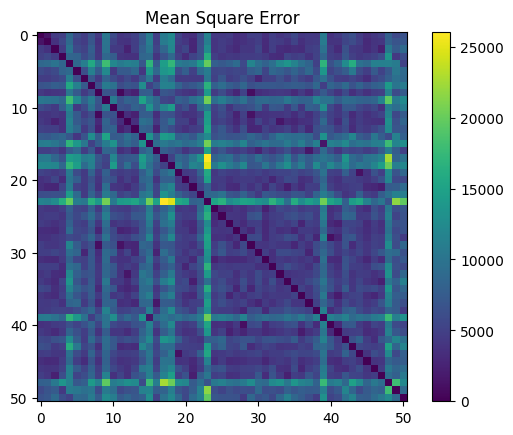

In [45]:
compare(path_images, mse, "Mean Square Error")

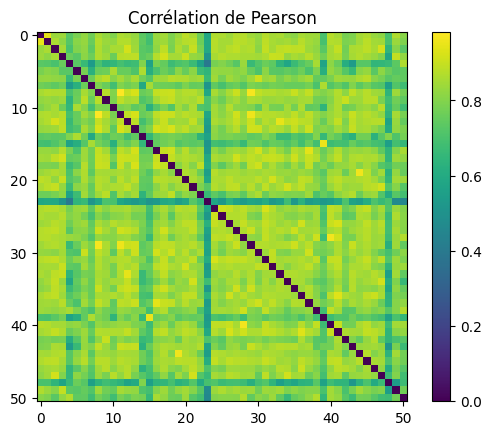

In [46]:
compare(path_images,pearson_correlation, "Corrélation de Pearson")

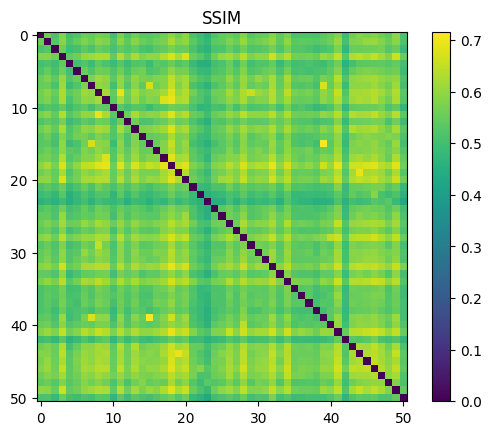

In [47]:
compare(path_images,ssim, "SSIM")